# Driver/Passenger Simulator 

This notebook simulates the behaviors of taxi drivers and passengers in a taxi booking system
[Mesa](http://mesa.readthedocs.io/en/latest/index.html) is used to build an agent based modeling system

The simulation assumes that there are two types of agents in the model, namely passengers and drivers

## Driver
Drivers behave in a way that they always search for the highest bid from passengers
They search within a region the passenger request with highest price and accpet the job
A job spans a centain period and when it finishes, the driver continues to look for another passenger

## Passenger
Passengers try to look for a taxi that can take them to the destination 
They are two types of passengers in this simulation

### Type 1
If they cannot find a taxi in the current time instant, they move to the neighboring area in the next time step

### Type 2:
If they cannot find a taxi in the current time instant, they raise the price by one unit until an upper limite is reached

It is assumed that are the trips in the simulation are of the same distance/time
Furthermore, it is assumed that passenger immediately looks for another taxi once a trip is finished

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
from mesa.space import MultiGrid
import numpy as np
from mesa.datacollection import DataCollector
from operator import attrgetter

# define the number of passengers and drivers
N_driver = 200
N_passenger = 200

In [2]:
class PassengerModel(Agent):
    def __init__(self,unique_id, model):
        super().__init__(unique_id, model)  # a unique_id for each passenger
        self.ask_price = 10  # in this version, all passengers have the same initial ask_price
        self.state = 1 # 1 1ooking for; 2 on a cab
        self.start_journey = 0  # record the time when boarding the taxi
        self.cost = 0 # accumulated expense of all trips
        self.journeys_time = 0 # record the number of trips taken
    
    # step() in Mesa describes the behavior of the agent at each time step
    def step(self):
        # if the agent is looking for a taxi
        if self.state == 1:
            # Group 1: physically search by moving more distance
            if self.unique_id <= N_passenger/2:
                self.move()
            # Group 2: raise the ask_price until an upper limit
            else:
                if self.ask_price <= 15:
                    self.ask_price += 1     
                    
        # if already in the taxi, check whether the drop-off timer expires 
        else:
            self.drop_off()
    
    # Group 1 passengers move in order to find a taxi
    def move(self):
        # an agent can only go to the neighboring block in one step
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True,include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def drop_off(self):
        if self.state == 2:
            # if the time expires, drop the passenger off and reset the related variables
            if self.model.time - self.start_journey >= 10:
                self.state = 1
                self.cost += self.ask_price
                self.journeys_time += 1
                self.ask_price = 10
                


In [3]:
class DriverModel(Agent):
    def __init__(self,unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 0  # accumulated earning
        self.state = 0   # 0: idle ; -1: occupied
        self.start_journey = 0
        self.jobs_time = 0 # accumuted number of jobs 
        self.passenger = None
    
    def step(self):
        # if the taxi is in idle state, the driver looks for passengers
        if self.state == 0:
            self.find_passenger()
        # otherwise it checks the drop-off timer
        else:
            self.drop_off_passenger()
            
    # driver selects a passenger based on the ask_price; the higest one is selected        
    def find_passenger(self):
        # find passengers in the same block
        gridmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(gridmates) > 1:
            passenger_list = [p for p in gridmates if p.unique_id <= N_passenger and p.state == 1]
            # if the driver finds one passenger, it sets the related variables
            if len(passenger_list) >= 1:
                selected_passenger = max(passenger_list, key=attrgetter('ask_price'))
                self.wealth += selected_passenger.ask_price
                self.state = -1
                selected_passenger.state = 2
                selected_passenger.start_journey = self.model.time
                self.start_journey = self.model.time
                self.passenger = selected_passenger
        
    def move(self):
        # an agent can only go to the neighboring block in one step
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True,include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    
    def drop_off_passenger(self):
        if self.model.time - self.start_journey >= 10:
            self.state = 0
            self.jobs_time += 1
            self.model.grid.move_agent(self.passenger, self.pos)
        else:
            self.move()
        
            

In [4]:
[i for i in range(100, 105)]

[100, 101, 102, 103, 104]

In [5]:
# the model
class GrabModel(Model):
    def __init__(self, width, height, N_driver, N_passenger):
        self.num_drivers = N_driver
        self.num_passenger = N_passenger
        self.grid = MultiGrid(width, height,True)
        self.schedule = RandomActivation(self)
        self.time = 0
        
        for i in range(self.num_passenger):
            a = PassengerModel(i, self)          
            self.schedule.add(a)
            
            # passenger randomly distributed in 
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x,y))
            
        for i in range(self.num_passenger, self.num_passenger+self.num_drivers):
            a = DriverModel(i,self)          
            self.schedule.add(a)
            
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x,y)) 
            
        self.datacollector = DataCollector(
            #model_reporters={"Gini": compute_gini},
            agent_reporters={"Pay": lambda a: a.unique_id})  
        
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.time += 1

In [6]:
model = GrabModel(10,10,N_driver,N_passenger)
for i in range(1000):
    model.step()
    


854.5 28.6294319713


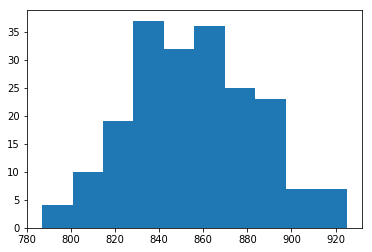

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
agent_wealth = [a.wealth for a in model.schedule.agents if a.unique_id >= N_passenger]
plt.hist(agent_wealth)
print(np.median(agent_wealth), np.std(agent_wealth))


(array([  8.,  14.,  22.,  25.,  26.,  33.,  24.,  30.,  13.,   5.]),
 array([ 77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.]),
 <a list of 10 Patch objects>)

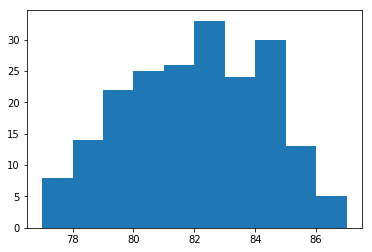

In [8]:
agent_jobs_time = [a.jobs_time for a in model.schedule.agents if a.unique_id >= N_passenger]
plt.hist(agent_jobs_time)

(array([  1.,   0.,   2.,   6.,   7.,  15.,  37.,  25.,   7.,   1.]),
 array([ 58. ,  60.8,  63.6,  66.4,  69.2,  72. ,  74.8,  77.6,  80.4,
         83.2,  86. ]),
 <a list of 10 Patch objects>)

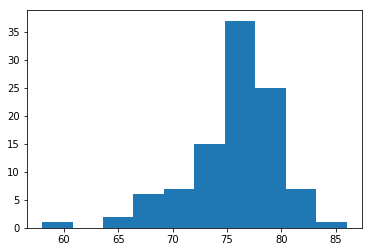

In [9]:
agent_journeys_time = [a.journeys_time for a in model.schedule.agents if a.unique_id <= N_passenger/2]
plt.hist(agent_journeys_time)

(array([  2.,   1.,   2.,   5.,   8.,   8.,  35.,  22.,   9.,   8.]),
 array([ 79. ,  80.3,  81.6,  82.9,  84.2,  85.5,  86.8,  88.1,  89.4,
         90.7,  92. ]),
 <a list of 10 Patch objects>)

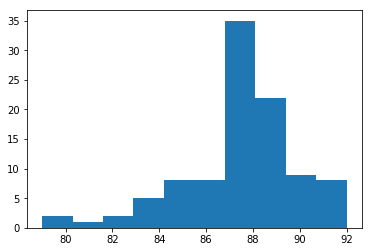

In [10]:
agent_jobs_time = [a.journeys_time for a in model.schedule.agents if a.unique_id >= N_passenger/2 and a.unique_id < N_passenger]
plt.hist(agent_jobs_time)

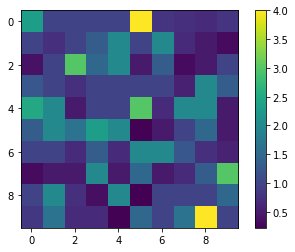

In [11]:
driver_counts = np.zeros((model.grid.width,model.grid.height))
ratio_counts = np.zeros((model.grid.width,model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    driver_count = len([a for a in cell_content if a.unique_id >= N_passenger])
    driver_counts[x][y] = driver_count
    passenger_count = len([a for a in cell_content if a.unique_id <= N_passenger])
    ratio_counts[x][y] = (passenger_count+1)/(driver_count+1)  #avoid division by 0
plt.imshow(ratio_counts, interpolation='nearest')
plt.colorbar()


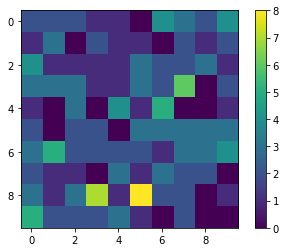

In [12]:
plt.imshow(driver_counts, interpolation='nearest')
plt.colorbar()